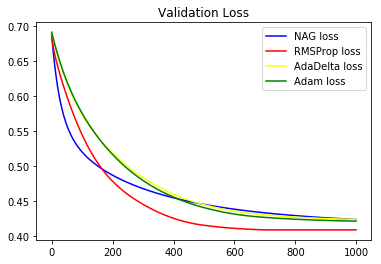

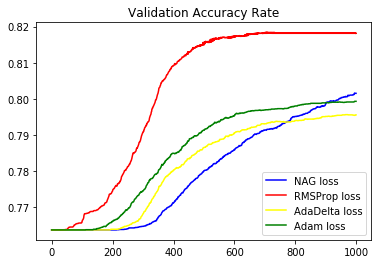

In [5]:
# write your code here
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

def h(w, x):
    return 1/(1 + np.exp(- x.dot(w)))

# 计算梯度, x中包含 n 个样本，根据这 n 个样本计算梯度
def gradient(X, y, w,λ=0.1):
    row,col= w.shape
    grad = - y * X /(1 + np.exp(y * X.dot(w)))
    return np.mean(grad, axis=0).reshape(row,col)+w*λ

# 根据模型预测，θ为阈值
def prediction(X, w, θ=0.5):
    row, col = X.shape
    p = np.ones((row, 1))
    b = h(w, X) < θ
    b = b.ravel()
    p[b,:] = -1
    return p

def Loss(X, y, w, λ=0.01):
    row, col = X.shape
    loss_mat = np.log(1 + np.exp(-y * X.dot(w)))
    return loss_mat.mean()+λ*0.5*w.T.dot(w)/row

# 计算分类正确率
def Rate(y_real, y_prediction):
    row, col = y_real.shape
    mat = np.zeros([row, 1])
    b = (y_real == y_prediction)
    b = b.ravel()
    mat[b,:] = 1
    return mat.sum()/row

# NAG, T是训练轮数， λ为正则化参数
def NAG(X, y, X_test, y_test, T, batch, η=0.01, γ=0.01, λ=0.01):
    row,col = X.shape
    random = np.array(np.random.random_sample(batch)*row,dtype=int)
    x = X[random,:]
    y = y[random,:]
    w = np.zeros((col,1))
    v = np.zeros((col,1))
    loss = np.zeros(T)
    rate = np.zeros(T)
    for i in range(T):
        g = gradient(x, y, w - γ* v)
        v = γ * v + η * g
        w = w - v
        loss[i] = Loss(X_test, y_test, w)
        y_prediction = prediction(X_test, w)
        rate[i] = Rate(y_test, y_prediction)
    return loss,rate

def RMSProp(X, y, X_test, y_test, T, batch, η=0.0005, γ=0.9):
    row,col = X.shape
    random = np.array(np.random.random_sample(batch)*row,dtype=int)
    x = X[random,:]
    y = y[random,:]
    w = np.zeros((col,1))
    G = np.zeros((col,1))
    e = 1 * 10**(-8)
    loss = np.zeros(T)
    rate = np.zeros(T)
    for i in range(T):
        g = gradient(x, y, w)
        G = γ * G + (1 - γ)* g * g
        w = w - (η/np.sqrt(G+e)) * g 
        #w = w - η*g
        loss[i] = Loss(X_test, y_test, w)
        y_prediction = prediction(X_test, w)
        rate[i] = Rate(y_test, y_prediction)
    return loss,rate

def AdaDelta(X, y, X_test, y_test, T, batch, η=0.0005, γ=0.95):
    row,col = X.shape
    random = np.array(np.random.random_sample(batch)*row,dtype=int)
    x = X[random,:]
    y = y[random,:]
    w = np.zeros((col,1))
    G = np.zeros((col,1))
    delta = np.zeros((col,1))
    e = 1 * 10**(-8)
    loss = np.zeros(T)
    rate = np.zeros(T)
    for i in range(T):
        g = gradient(x, y, w)
        G = γ * G + (1 - γ)* g * g
        w_delta = - np.sqrt(delta+e)/np.sqrt(G+e) * g
        w = w + w_delta
        delta = γ* delta + (1 - γ)*w_delta*w_delta
        loss[i] = Loss(X_test, y_test, w)
        y_prediction = prediction(X_test, w)
        rate[i] = Rate(y_test, y_prediction)
    return loss,rate

def Adam(X, y, X_test, y_test, T, batch, η=0.001, γ=0.999, β=0.9):
    row,col = X.shape
    random = np.array(np.random.random_sample(batch)*row,dtype=int)
    x = X[random,:]
    y = y[random,:]
    w = np.zeros((col,1))
    m = np.zeros((col,1))
    G = np.zeros((col,1))
    delta = np.zeros((col,1))
    e = 1 * 10**(-8)
    loss = np.zeros(T)
    rate = np.zeros(T)
    for i in range(T):
        g = gradient(x, y, w)
        m = β* m + (1-β) * g
        G = γ * G + (1 - γ)* g * g
        α = η * np.sqrt(1-γ**i)/(1-β**i)
        w = w - α* m/np.sqrt(G+e)
        loss[i] = Loss(X_test, y_test, w)
        y_prediction = prediction(X_test, w)
        rate[i] = Rate(y_test, y_prediction)
    return loss,rate

# 从文件中加载数据并对数据进行预处理
def load(file_name, features=123):
    X, y = load_svmlight_file(file_name, n_features=features)
    row, col = X.shape
    X = X.toarray()
    X = np.column_stack((X, np.ones((row,1))))
    y = y.reshape(row,1)
    return X, y 
    
# 加载数据并分离测试集和验证集
X_train, y_train = load('a9a.txt')
X_validation, y_validation = load('a9a.t.txt')

# 初始化数据, batch是批量梯度下降的批量数,
iteration = 1000
batch = 500
                       
            
loss_NAG, rate_NAG = NAG(X_train, y_train, X_validation, y_validation, batch=batch,T = iteration)
loss_Prop, rate_Prop = RMSProp(X_train, y_train, X_validation, y_validation, batch=batch,T = iteration)
loss_AdaDelta, rate_AdaDelta = AdaDelta(X_train, y_train, X_validation, y_validation, batch=batch,T = iteration)
loss_Adam, rate_Adam = AdaDelta(X_train, y_train, X_validation, y_validation, batch=batch,T = iteration)
                       

# 绘图
x_axis = range(iteration)

plt.figure()
plt.title("Validation Loss")
plt.plot(x_axis, loss_NAG,color="blue",label="NAG loss")
plt.plot(x_axis, loss_Prop,color="red",label="RMSProp loss")
plt.plot(x_axis, loss_AdaDelta,color="yellow",label="AdaDelta loss")
plt.plot(x_axis, loss_Adam,color="green",label="Adam loss")
plt.legend(loc = "upper right")
plt.show()

plt.figure()
plt.title("Validation Accuracy Rate")
plt.plot(x_axis, rate_NAG,color="blue",label="NAG loss")
plt.plot(x_axis, rate_Prop,color="red",label="RMSProp loss")
plt.plot(x_axis, rate_AdaDelta,color="yellow",label="AdaDelta loss")
plt.plot(x_axis, rate_Adam,color="green",label="Adam loss")
plt.legend(loc = "lower right")
plt.show()







f:\python\install\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
f:\python\install\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


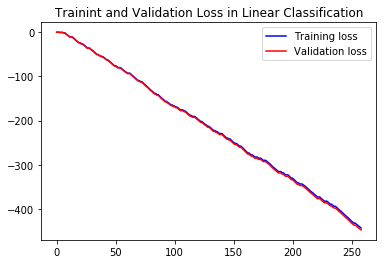

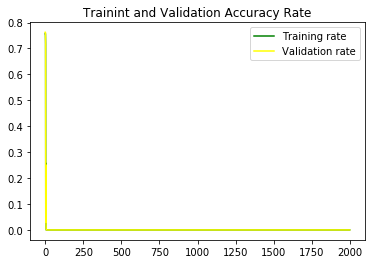

In [10]:
# write your code here
-







In [3]:
import numpy as np
a = np.array([4,6,9, 40,60,90]).reshape(3,2)
b = np.array([2,2,2]).reshape(3,1)
a/b

array([[  2. ,   3. ],
       [  4.5,  20. ],
       [ 30. ,  45. ]])